# Dataprocessing the Pecan dataset using pandas

### Importing libraries

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import datetime
plt.style.use('ggplot')
import matplotlib.dates as dates
import warnings
warnings.filterwarnings("ignore")

# plots directory
figure_directory= 'figures/'
# change so that all figures have font size defulat as 22
plt.rcParams.update({'font.size': 18})
# figure size always the same
plt.figure(figsize=(16,12))

<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

In [4]:
import os
import sys
import pandas as pd
from collections import defaultdict
import glob

In [48]:
def read_data():
    df = pd.DataFrame()
    houses = []
    path = "datasets/*.csv"
    for fname in glob.glob(path):
        house_df = pd.read_csv(fname)
        houseID = int(fname.split('.')[0].split('\\')[1])
        
        house_df['DateTime'] = pd.to_datetime(house_df['DateTime'])
        mask = (house_df['DateTime'] >= '2014-1-1') & (house_df['DateTime'] < '2015-1-1')
        house_df = house_df.loc[mask]
        house_df = house_df.set_index('DateTime')
        house_df = house_df.resample('1H').first()  # resample from 15 mins to 1 hour 
        house_df = house_df.reset_index(drop=False)
        
        if len(house_df) == 8760 and house_df.isnull().sum().sum() <= 100: # one year hours 
            houses.append(houseID)
            house_df.columns = ['localhour', 'use', 'air1', 'furnace1', 'dishwasher1', 'regrigerator1']  
            house_df = house_df.fillna(method='pad') 
            house_df['regrigerator1'] = house_df['regrigerator1'].fillna(method='ffill')
            appliances_sum = house_df[['air1', 'furnace1', 'dishwasher1', 'regrigerator1']].sum(axis=1)
            house_df['other'] = house_df['use'].subtract(appliances_sum)
            house_df['house'] = houseID
            house_df = house_df.set_index('house')
           
            df = pd.concat([df, house_df])
                               
    return df, houses

df, houses = read_data()
df.head()

,localhour,use,air1,furnace1,dishwasher1,regrigerator1,other
house,,,,,,,
135,2014-01-01 00:00:00,1.043,0.840,0.064,0.0,0.0,0.139
135,2014-01-01 01:00:00,0.158,0.000,0.009,0.0,0.0,0.149
135,2014-01-01 02:00:00,1.097,0.759,0.060,0.0,0.0,0.278
135,2014-01-01 03:00:00,0.715,0.522,0.045,0.0,0.0,0.148
135,2014-01-01 04:00:00,0.111,0.000,0.009,0.0,0.0,0.102


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183960 entries, 135 to 94
Data columns (total 7 columns):
localhour        183960 non-null datetime64[ns]
use              183960 non-null float64
air1             183960 non-null float64
furnace1         183960 non-null float64
dishwasher1      183960 non-null float64
regrigerator1    183960 non-null float64
other            183960 non-null float64
dtypes: datetime64[ns](1), float64(6)
memory usage: 11.2 MB


In [54]:
df.describe()

,use,air1,furnace1,dishwasher1,regrigerator1,other
count,183960.000000,183960.000000,183960.000000,183960.000000,183960.000000,183960.000000
mean,0.998322,0.251435,0.090556,0.009490,0.087300,0.559541
std,1.300115,0.652966,0.308043,0.075677,0.093179,0.845629
min,0.000000,0.000000,0.000000,0.000000,0.000000,-0.055000
25%,0.233000,0.000000,0.005000,0.000000,0.006000,0.141000
50%,0.484000,0.000000,0.012000,0.000000,0.074000,0.283000
75%,1.182000,0.018000,0.056000,0.000000,0.130000,0.562000
max,21.436000,4.411000,10.971000,1.378000,1.486000,12.751000


In [50]:
def format_data(df, houses):
    '''
    Parameters: dataframe of the apppliacnes
    Return: dictionary contains all X^T x m
    '''
    d = {}
    for appliance in df.columns.tolist():
        started = 0
        for i in houses:
            if started == 0:

                d[str(appliance)] = df[[str(appliance)]][df[str(appliance)].index == i]
                started = 1
                dfindex = d[str(appliance)].index
    
            else:
                d[str(appliance)][str(i)] = pd.Series(df[str(appliance)][df[str(appliance)].index == i].values,index=dfindex)


        d[str(appliance)]=d[str(appliance)].rename(columns = {str(appliance):str(dfindex[0])})
        d[str(appliance)].reset_index(drop=True, inplace=True)
    return d
    
dic = format_data(df, houses)
dic['use'].head(5)

,135,2004,2034,2156,2171,2242,2710,275,2829,2845,...,3273,3443,3678,3687,3721,3873,3938,508,898,94
0,1.043,0.555,0.713,2.947,2.177,1.194,6.749,1.518,0.397,1.160,...,1.800,0.135,1.167,1.107,0.511,0.163,0.177,0.108,0.410,1.561
1,0.158,0.504,0.658,1.460,1.058,1.185,2.181,1.414,0.381,1.087,...,5.010,0.096,0.521,1.717,0.636,0.268,0.082,0.102,0.488,1.421
2,1.097,0.503,1.641,1.353,0.343,1.307,1.345,1.090,0.300,0.951,...,2.939,1.300,0.649,1.010,1.736,0.163,0.082,0.101,0.531,1.434
3,0.715,0.460,1.397,1.836,1.398,1.515,3.884,0.976,0.262,0.481,...,0.080,0.086,0.133,0.987,0.155,0.154,0.187,0.101,0.222,1.283
4,0.111,0.535,0.444,1.345,0.420,1.175,2.015,1.004,0.225,0.450,...,0.091,0.134,0.217,0.634,0.053,0.051,0.083,5.169,0.222,1.147


In [51]:
key = list(dic.keys())
key
# columns = dic[key].columns.tolist()

['localhour',
 'use',
 'air1',
 'furnace1',
 'dishwasher1',
 'regrigerator1',
 'other']

In [12]:
def split(d,portion,timeframe, portion_houses=None, option=None):
    '''
    Parameters: d = dictionary, portion 0.5 - 0.9, timeframe 1-8760

    Return: x_train,x_test dictionarys containing dataframes of all the appliances within the timeframe.
    '''

    x_train = {}
    x_test = {}
    timeframe = range(timeframe)
    columns = list(dic.keys())
    train_list  = timeframe[int(len(timeframe) * 0.0):int(len(timeframe) * portion)]
    test_list = timeframe[int(len(timeframe) * portion):int(len(timeframe) * 1.0)]
    '''
    start_day_2014 = 3 # thursday
    if option == 'week':
        for key in d.keys():
            x_train[key] = d[key].loc
    '''
    if portion_houses != None:
        houses  = columns[int(len(columns) * 0.0): int(len(columns) * portion_houses)]

    for key in d.keys():

        if portion_houses != None:
            x_train[key] = d[key].loc[train_list,houses]
            x_test[key] = d[key].loc[test_list,houses]
        else:
            x_train[key] = d[key].loc[train_list,:]
            x_test[key] = d[key].loc[test_list,:]

    return x_train,x_test

### Splitting the dataframes into portions of a month

In [ ]:
t = 12

x_train,x_test = split(dic, 0.5, t)
x_train_use = x_train.pop('use',None)
x_test_use = x_test.pop('use',None)
x_train_localhour = x_train.pop('localhour',None)
x_test_localhour = x_test.pop('localhour',None)

In [ ]:
x_train[list(x_train.keys())[0]].shape

In [ ]:
x_train.values()

## Splitting into weekdays and weekends

In [13]:
week = pd.DatetimeIndex(pd.to_datetime(df['localhour'])).weekday
weekdays = np.in1d(week.ravel(),range(5)).reshape(week.shape)
weekends = week[np.where(week > 4,week,0)]
weekends = np.in1d(week.ravel(),[5,6]).reshape(week.shape)

In [14]:
df[weekdays].describe()

,use,air1,furnace1,dishwasher1,regrigerator1,other
count,169128.000000,169128.000000,169128.000000,169128.000000,169128.000000,169128.000000
mean,1.111529,0.263679,0.096716,0.010013,0.086110,0.655011
std,1.471074,0.654062,0.328888,0.076613,0.089393,1.000448
min,0.000000,0.000000,0.000000,0.000000,0.000000,-4.678637
25%,0.267000,0.000000,0.006000,0.000000,0.008000,0.150000
50%,0.508000,0.000000,0.011000,0.000000,0.074000,0.309000
75%,1.311000,0.037000,0.056000,0.000000,0.127000,0.643000
max,21.436000,4.374000,10.971000,1.378000,1.566000,12.232000


In [59]:
df[weekends].to_csv('weekendpecanhour2014')
df[weekdays].to_csv('weekdayspecanhour2014')

ValueError: Item wrong length 236520 instead of 67392.

In [ ]:
df[weekends].describe()

### Data Exploration

In [17]:
local = df['localhour'].tolist()
import datetime, re
xticks = map(lambda x: re.split('\s',x)[0],local)

### Usage for texas is like a poisson distribution, could be used in future research

0.6248749145318595 1.3711250854681387


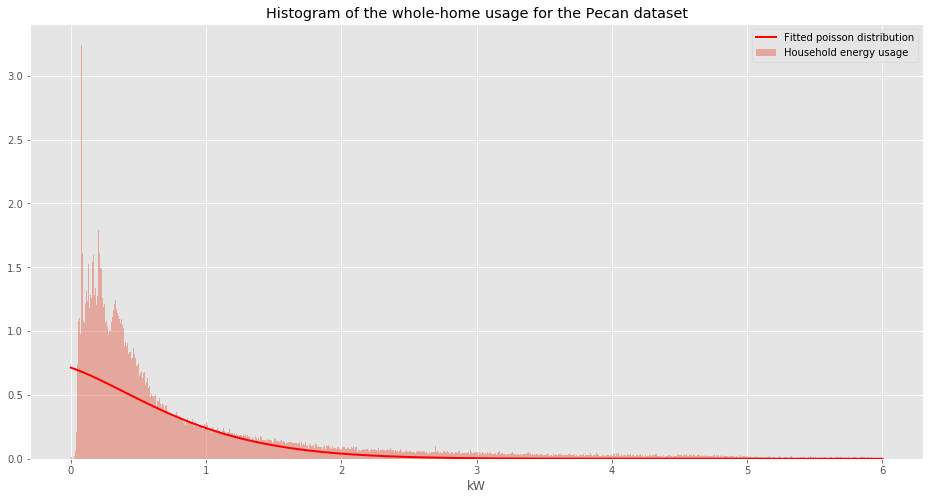

In [52]:
from scipy.optimize import curve_fit
from scipy.special import factorial
from scipy import stats
plt.figure(figsize=(16,8))

#df_plot = np.where(df['use'].values < 6)
df_plot = df['use'].values[np.where(df['use'].values < 6)]
#entries, bin_edges, patches = df_plot[df_plot < 6].hist(bins=1000, figsize=(16,12),normed=True)
# get poisson deviated random numbers
data = np.random.poisson(2, 1000)
entries, bin_edges, patches = plt.hist(df_plot,bins=1000,normed=True,label='Household energy usage', alpha=0.4)

# the bins should be of integer width, because poisson is an integer distribution
#entries, bin_edges, patches = plt.hist(data, bins=11, range=[-0.5, 10.5], normed=True)

# calculate binmiddles
bin_middles = 0.5*(bin_edges[1:] + bin_edges[:-1])

# poisson function, parameter lamb is the fit parameter
def poisson(k, lamb):
    return (lamb**k/factorial(k)) * np.exp(-lamb)

def weib(x,n,a):
    return (a / n) * (x / n)**(a - 1) * np.exp(-(x / n)**a)

(loc, scale) = stats.exponweib.fit_loc_scale(data, 1, 1)
print(loc, scale)

# fit with curve_fit
parameters, cov_matrix = curve_fit(poisson, bin_middles, entries) 

# plot poisson-deviation with fitted parameter
x_plot = np.linspace(0, 6, 1000)

# plt.plot(x, weib(x, loc, scale))
# plt.hist(data, data.max(), normed=True)
curve = plt.plot(x_plot, poisson(x_plot, *parameters), 'r-', lw=2,label='Fitted poisson distribution')

plt.title('Histogram of the whole-home usage for the Pecan dataset')
plt.xlabel('kW')
plt.legend()

# plt.savefig(figure_directory+'histusage.png')

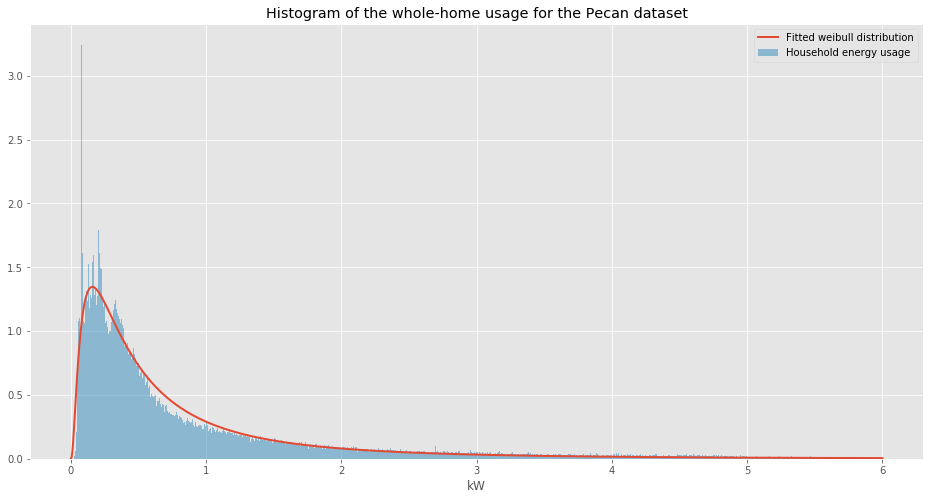

In [53]:
from scipy import stats
plt.figure(figsize=(16,8))
x_plot = np.linspace(0, 6, 1000)
#df_plot = np.where(df['use'].values < 6)
df_plot = df['use'].values[np.where(df['use'].values < 6)]
plt.plot(x_plot, stats.exponweib.pdf(x_plot, *stats.exponweib.fit(df_plot, 1, 1, scale=0.2, loc=0)),lw=2,label='Fitted weibull distribution')
_ = plt.hist(df_plot, bins=1000, normed=True, alpha=0.5, label='Household energy usage');

plt.title('Histogram of the whole-home usage for the Pecan dataset')
plt.xlabel('kW')
plt.legend()

# plt.savefig(figure_directory+'new_histusage.png')

Text(0, 0.5, 'kW')

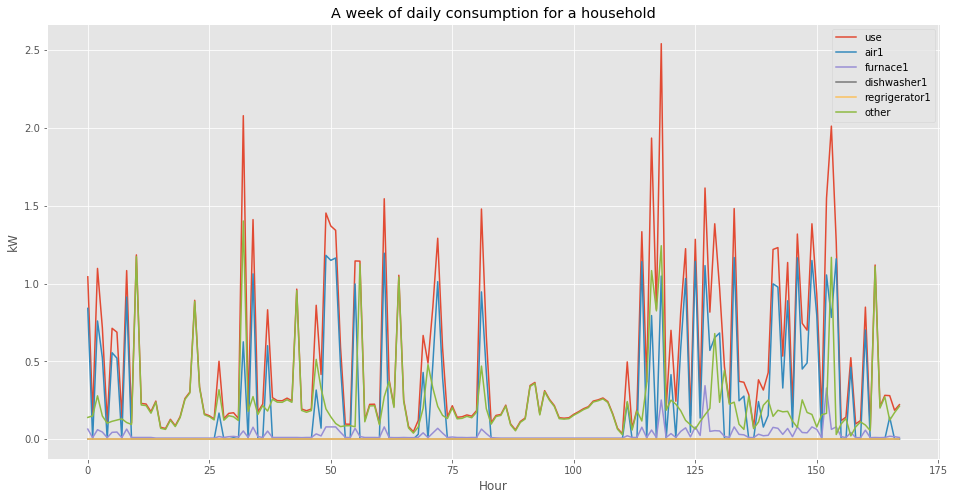

In [55]:
df_test = df.copy()
df_test.drop('localhour', axis=1, inplace=True)
hours = 24*7
df_test[0:hours].reset_index(drop=True).plot(figsize=(16,8))
plt.title('A week of daily consumption for a household')
plt.xlabel('Hour')
plt.ylabel('kW')

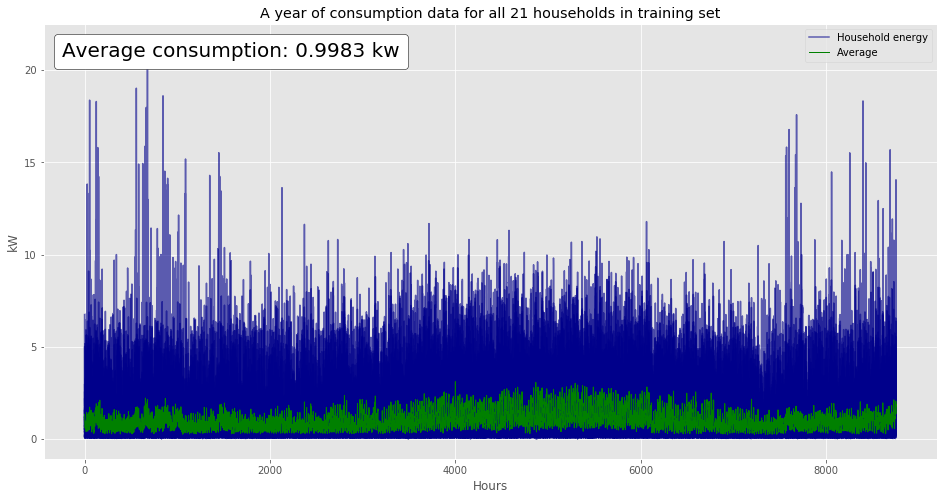

In [56]:
import numpy.ma as ma

df_sort =df.set_index(df['localhour']).sort_index(by='localhour')
average_use = list(map(lambda x: df_sort.loc[x,'use'].mean(),df_sort.index.unique()))
leng = len(average_use)

mean_use = np.mean(np.where(np.isnan(average_use), ma.array(average_use, mask=np.isnan(average_use)).mean(axis=0), average_use))

fig, ax = plt.subplots(figsize=(16,8))
houses = df.index.unique()
i = 0
for house in houses:
    df.loc[house,'use'].reset_index(drop=True).plot(color='DarkBlue', alpha=0.6, label='Household energy' if i == 0 else '', ax=ax)
    i += 1

s = pd.Series(average_use)

s_df = pd.DataFrame({'Average':s})
#df_use.set_index()

s_df.plot(color='green',label='Average Use',lw=1, ax=ax)

plt.title('A year of consumption data for all {} households in training set'.format(len(houses)))
plt.xlabel('Hours')
plt.ylabel('kW')
from collections import OrderedDict
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
at = AnchoredText("Average consumption: {:.4f} kw".format(mean_use),
                  prop=dict(size=20), frameon=True,
                  loc=2,
                  )

at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)

### plotting the weekend household use of the week dataset

In [60]:
df = pd.read_csv('weekendpecanhour2014')
df = df.set_index(df['house'])
df_sort =df.set_index(df['localhour']).sort_index(by='localhour')
average_use = list(map(lambda x: df_sort.loc[x,'use'].mean(),df_sort.index.unique()))
leng = len(average_use)
df.head()

,house,localhour,use,air1,furnace1,dishwasher1,regrigerator1,other
house,,,,,,,,
135,135,2014-01-04 00:00:00,1.291,1.012,0.069,0.0,0.0,0.210
135,135,2014-01-04 01:00:00,0.586,0.396,0.038,0.0,0.0,0.152
135,135,2014-01-04 02:00:00,0.142,0.000,0.010,0.0,0.0,0.132
135,135,2014-01-04 03:00:00,0.214,0.000,0.013,0.0,0.0,0.201
135,135,2014-01-04 04:00:00,0.140,0.000,0.010,0.0,0.0,0.130


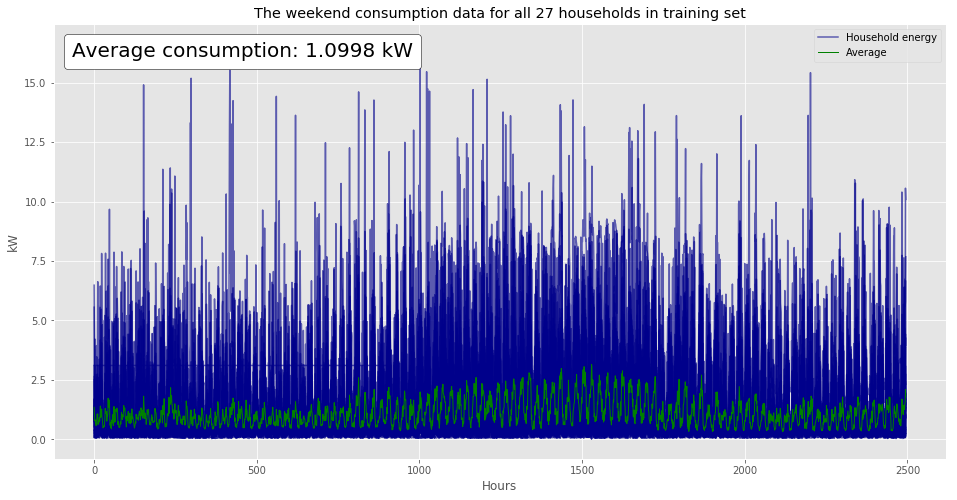

In [61]:
fig, ax = plt.subplots(figsize=(16, 8))
houses = df.index.unique()
i = 0
for house in houses:
    df.loc[house,'use'].reset_index(drop=True).plot(color='DarkBlue', alpha=0.6, label='Household energy' if i == 0 else '', ax=ax)
    i += 1

mean_use = np.mean(np.where(np.isnan(average_use), ma.array(average_use, mask=np.isnan(average_use)).mean(axis=0), average_use))
    
s = pd.Series(average_use)
s_df = pd.DataFrame({'Average':s})
#df_use.set_index()

s_df.plot(color='Green',label='Average Use',lw=1, ax=ax)

plt.title('The weekend consumption data for all {} households in training set'.format(len(houses)))
plt.xlabel('Hours')
plt.ylabel('kW')
from collections import OrderedDict
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
at = AnchoredText("Average consumption: {:.4f} kW".format(mean_use),
                  prop=dict(size=20), frameon=True,
                  loc=2,
                  )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)

In [62]:
df = pd.read_csv('weekdayspecanhour2014')
df = df.set_index(df['house'])
df_sort =df.set_index(df['localhour']).sort_index(by='localhour')
average_use = list(map(lambda x: df_sort.loc[x,'use'].mean(),df_sort.index.unique()))
leng = len(average_use)
df.head()

,house,localhour,use,air1,furnace1,dishwasher1,regrigerator1,other
house,,,,,,,,
135,135,2014-01-01 00:00:00,1.043,0.840,0.064,0.0,0.0,0.139
135,135,2014-01-01 01:00:00,0.158,0.000,0.009,0.0,0.0,0.149
135,135,2014-01-01 02:00:00,1.097,0.759,0.060,0.0,0.0,0.278
135,135,2014-01-01 03:00:00,0.715,0.522,0.045,0.0,0.0,0.148
135,135,2014-01-01 04:00:00,0.111,0.000,0.009,0.0,0.0,0.102


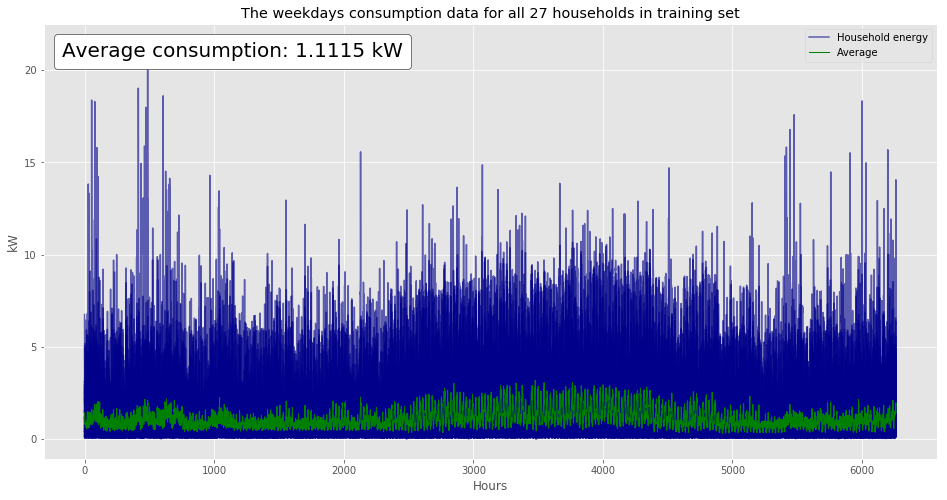

In [63]:
fig, ax = plt.subplots(figsize=(16, 8))
houses = df.index.unique()
i = 0
for house in houses:
    df.loc[house,'use'].reset_index(drop=True).plot(color='DarkBlue', alpha=0.6, label='Household energy' if i == 0 else '', ax=ax)
    i += 1

mean_use = np.mean(np.where(np.isnan(average_use), ma.array(average_use, mask=np.isnan(average_use)).mean(axis=0), average_use))
    
s = pd.Series(average_use)
s_df = pd.DataFrame({'Average':s})
#df_use.set_index()

s_df.plot(color='Green',label='Average Use',lw=1, ax=ax)

plt.title('The weekdays consumption data for all {} households in training set'.format(len(houses)))
plt.xlabel('Hours')
plt.ylabel('kW')
from collections import OrderedDict
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
at = AnchoredText("Average consumption: {:.4f} kW".format(mean_use),
                  prop=dict(size=20), frameon=True,
                  loc=2,
                  )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)